A Minsky Moment refers to a sudden and severe market collapse following a prolonged period of market speculation or unsustainable growth. The term is named after economist Hyman Minsky, who theorized that financial markets are inherently unstable and that long periods of prosperity and rising asset prices often lead to increasing levels of debt and risk-taking. This, in turn, makes the financial system more vulnerable to a sudden downturn.

In essence, a Minsky Moment occurs when investors suddenly realize that the levels of debt and speculative investments are unsustainable, leading to a rapid sell-off of assets and a sharp decline in market values. This can trigger a financial crisis as asset prices plummet and liquidity dries up.

Key characteristics of a Minsky Moment include:

High Debt Levels: Accumulation of excessive debt during periods of economic stability and rising asset prices.
Speculative Investments: Increased risk-taking and speculative investments based on the assumption that market conditions will remain favorable.
Market Realization: A sudden recognition by investors that the speculative bubble is unsustainable, leading to a swift and significant market downturn.
Understanding Minsky Moments is crucial for economists and financial analysts in anticipating and mitigating the risks of financial crises.

The theory of Minsky Moments and Minsky's broader financial instability hypothesis have faced several criticisms. Here are some of the key points of critique:

Lack of Predictive Power:

Critics argue that while Minsky’s theory explains why financial crises happen, it lacks precise predictive power. It does not specify when and how exactly a financial crisis will occur, making it more of a descriptive than a predictive tool.
Overemphasis on Debt:

Some economists believe that Minsky’s theory places too much emphasis on debt as the primary driver of financial instability. They argue that other factors, such as changes in technology, regulation, or external economic shocks, can also play significant roles in causing financial crises.
Neglect of Market Corrections:

Critics point out that Minsky’s hypothesis underestimates the self-correcting mechanisms of markets. They argue that markets often adjust to excessive debt and speculative bubbles through regulatory measures, market discipline, and other stabilizing factors without necessarily leading to a crisis.
Limited Empirical Evidence:

There is a claim that Minsky’s theory lacks robust empirical support. While there are instances that seem to align with Minsky’s predictions, critics argue that there are also many periods of high debt and speculation that did not result in financial crises.
Generalization Issues:

The theory is sometimes seen as too general and not accounting for the specific conditions and regulatory environments of different economies. What triggers a financial crisis in one country may not have the same effect in another due to varying economic structures and policies.
Policy Implications:

Some critics argue that the policy implications of Minsky’s theory are not clear or practical. If financial instability is an inherent feature of capitalism, as Minsky suggests, then it is challenging to devise effective policies to prevent financial crises without stifling economic growth and innovation.
Neglect of Positive Economic Contributions of Debt:

Minsky’s focus on the dangers of debt may overlook the positive aspects of borrowing and lending, which are essential for economic growth. Debt can be used for productive investments that drive economic progress, and not all debt accumulation leads to instability.
In summary, while Minsky’s theory provides valuable insights into the dynamics of financial markets and the potential for crises, it is not without its critics. The criticisms mainly revolve around its predictive limitations, overemphasis on debt, lack of empirical evidence, and the challenges of deriving practical policy measures from the theory.

This project empirically tests Minsky's theory that financial instability is an 'Economic Law of Motion' of Capitalism. We will use a unit root test to detect explosive behavior in predicted stock index prices, examining their long-run relationship with GDP and the implications for potential bubbles.


In [457]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import VECM

path = '/Users/philiplacava/Projects/DSCI 521/Bubble project/'
# Define file paths
Brazil_gdp = 'Asset-Price-Bubble-Detection/GDP Data/Brazil_GDP.csv'
Japan_gdp = 'Asset-Price-Bubble-Detection/GDP Data/Japan_GDP.csv'
Germany_gdp = 'Asset-Price-Bubble-Detection/GDP Data/Germany_GDP.csv'
India_gdp = 'Asset-Price-Bubble-Detection/GDP Data/India_GDP.csv'
Mexico_gdp = 'Asset-Price-Bubble-Detection/GDP Data/Mexico_GDP.csv'
US_gdp = 'Asset-Price-Bubble-Detection/GDP Data/USGDP.csv'
df = pd.read_csv(path + Brazil_gdp)
# Rename the second column to 'GDP'
df.columns.values[1] = 'GDP'
df.reset_index(drop=True, inplace=True)
print(df)


           DATE       GDP
0    1996-01-01  175747.9
1    1996-04-01  177234.8
2    1996-07-01  184115.8
3    1996-10-01  182292.1
4    1997-01-01  183937.7
..          ...       ...
106  2022-07-01  317484.6
107  2022-10-01  317114.0
108  2023-01-01  321679.6
109  2023-04-01  324847.7
110  2023-07-01  325317.2

[111 rows x 2 columns]


First, pick a stock you would like to forcast from yahoo finance. For the purposes of demonstration we will use quarterly data of the DJIA 

In [458]:
# Read stock data from yfinance 
# ^IXIC Nasdaq
# ^GSPC S&P
# ^DJA Dow
# Brazil Index ^BVSP
# India Index  ^BSESN
# Germany ^GDAXI
# Japan ^N225
# Mexico ^MXX

ticker = ['^BVSP']
start = df['DATE'].iloc[0]
end = df['DATE'].iloc[-1]
data = yf.download(ticker, start, end, interval='3mo')['Close']
price = data.values.flatten()
T = len(price)

# Create a date range and set frequency
date = pd.date_range(start=start, periods=T, freq='Q-DEC')


# Generating log differences data for analysis
log_price = np.array(np.log(price))
delta_log_price = log_price[1:] - log_price[:-1]

date_diff = date[1:]
stock_data = pd.DataFrame({'price': price}, index=date)

print(len(price))
print(len(date))
stock_data


[*********************100%%**********************]  1 of 1 completed

110
110



/var/folders/gj/ntyx2j3d1rdf_dqn_fckn5pr0000gn/T/ipykernel_55191/2931662077.py:19: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  date = pd.date_range(start=start, periods=T, freq='Q-DEC')


,price
1996-03-31,4954.899902
1996-06-30,6043.899902
1996-09-30,6446.899902
1996-12-31,7039.899902
1997-03-31,9044.000000
...,...
2022-06-30,98542.000000
2022-09-30,110037.000000
2022-12-31,110031.000000
2023-03-31,101882.000000


After investigating the stock data we see that GDP is collected at the begining of the quarter while the Stock Index data is collected at the end, thus aligning a new dataframe must account for this by taking the first entry out of our GDP data and the last out of our stock data

In [461]:
gdp_df = df.iloc[1:] 
price_df = stock_data#.iloc[:-1] 
# adjust the first and last values of our data as needed
# ensure that the gdp and stock index dates are as closely aligned as possible
# varies by country
gdp_df = gdp_df.drop(columns= 'DATE')
gdp_df


,GDP
1,177234.8
2,184115.8
3,182292.1
4,183937.7
5,185607.5
...,...
106,317484.6
107,317114.0
108,321679.6
109,324847.7


In [462]:
gdp_series = pd.Series(gdp_df['GDP'].values)
price_df['GDP'] = gdp_series.values 
price_df['price_diff'] = price_df['price'].diff()
price_df['GDP_diff'] = price_df['GDP'].diff()
price_df = price_df.iloc[1:] # removing first row due to differencing creating NAN
price_df 

,price,GDP,price_diff,GDP_diff
1996-06-30,6043.899902,184115.8,1089.000000,6881.0
1996-09-30,6446.899902,182292.1,403.000000,-1823.7
1996-12-31,7039.899902,183937.7,593.000000,1645.6
1997-03-31,9044.000000,185607.5,2004.100098,1669.8
1997-06-30,12568.000000,187565.8,3524.000000,1958.3
...,...,...,...,...
2022-06-30,98542.000000,317484.6,-21457.000000,3306.2
2022-09-30,110037.000000,317114.0,11495.000000,-370.6
2022-12-31,110031.000000,321679.6,-6.000000,4565.6
2023-03-31,101882.000000,324847.7,-8149.000000,3168.1


In [463]:
price_df.to_csv('price_data.csv', index=True)  # creating csv of this data

In order to use Vector error correction to forecast cointegrated series, we need to ensure our data is stationary. This is why we take first differences. 

Stationarity Test


In [464]:
# ADF test for GDP
#    Run Augmented Dickey-Fuller test on a given series.

#   Parameters:
#   series (pd.Series): Time series data.
#   regression_type (str): Type of regression ('c', 'ct', 'ctt', 'nc') to include in the test.
#                          'c' - Constant only (default)
#                          'ct' - Constant and trend
#                          'ctt' - Constant, linear and quadratic trend
#                          'nc' - No constant, no trend

def perform_adf_test(series, regression_type='ct'):
    """
    Perform an Augmented Dickey-Fuller test on a given time series.

    Parameters:
        series (pd.Series): The time series on which to perform the ADF test.
        regression_type (str): The type of regression ('c' for constant, 'ct' for constant and trend, 'ctt' for constant, and linear and quadratic trend, 'nc' for no constant, no trend).

    Returns:
        None
    """
    result = adfuller(series, regression=regression_type)
    print(f"ADF Statistic for {series.name}: {result[0]}")
    print(f"p-value for {series.name}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[0] < result[4]['5%']:
        print(f"Reject the null hypothesis - the {series.name} series is stationary at the 95% confidence level.")
    else:
        print(f"Fail to reject the null hypothesis - the {series.name} series is not stationary at the 95% confidence level.")


In [465]:
perform_adf_test(price_df['GDP_diff'],regression_type='ct')
perform_adf_test(price_df['price_diff'],regression_type='ct')
perform_adf_test(price_df['price'],regression_type='ct')
perform_adf_test(price_df['GDP'],regression_type='ct')


ADF Statistic for GDP_diff: -8.382865242361962
p-value for GDP_diff: 9.331700904603933e-12
Critical Values:
	1%: -4.046
	5%: -3.452
	10%: -3.152
Reject the null hypothesis - the GDP_diff series is stationary at the 95% confidence level.
ADF Statistic for price_diff: -2.3507328399120264
p-value for price_diff: 0.4061169665494229
Critical Values:
	1%: -4.056
	5%: -3.457
	10%: -3.154
Fail to reject the null hypothesis - the price_diff series is not stationary at the 95% confidence level.
ADF Statistic for price: -3.213358317710694
p-value for price: 0.08177260335539005
Critical Values:
	1%: -4.056
	5%: -3.457
	10%: -3.154
Fail to reject the null hypothesis - the price series is not stationary at the 95% confidence level.
ADF Statistic for GDP: -1.4776310126294099
p-value for GDP: 0.8366659121637141
Critical Values:
	1%: -4.045
	5%: -3.452
	10%: -3.151
Fail to reject the null hypothesis - the GDP series is not stationary at the 95% confidence level.


Next we plot the significant lag effects of previous observations on GDP and Stock Price. Another check for stationarity. 

<Figure size 1000x500 with 0 Axes>

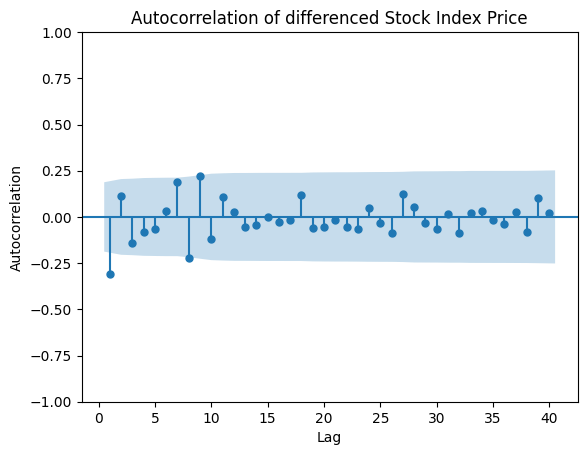

<Figure size 1000x500 with 0 Axes>

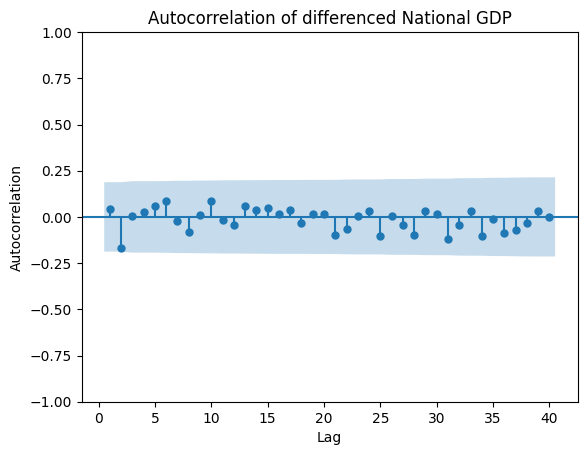

<Figure size 1000x500 with 0 Axes>

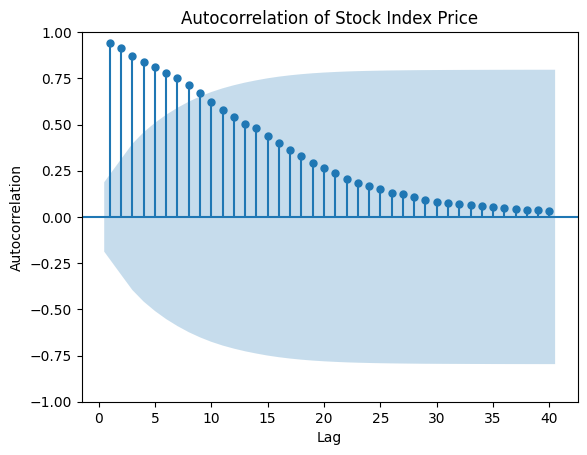

<Figure size 1000x500 with 0 Axes>

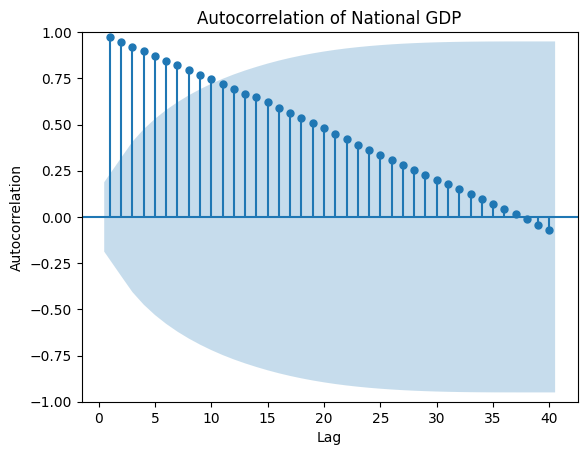

In [466]:
# Plot Correlogram for differenced Stock Index Price
plt.figure(figsize=(10, 5))
plot_acf(price_df['price_diff'], lags=40, zero=False, title='Autocorrelation of differenced Stock Index Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Plot Correlogram for differenced GDP
plt.figure(figsize=(10, 5))
plot_acf(price_df['GDP_diff'], lags=40, zero=False, title='Autocorrelation of differenced National GDP')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Plot Correlogram for DJIA Price
plt.figure(figsize=(10, 5))
plot_acf(price_df['price'], lags=40, zero=False, title='Autocorrelation of Stock Index Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Plot Correlogram for GDP
plt.figure(figsize=(10, 5))
plot_acf(price_df['GDP'], lags=40, zero=False, title='Autocorrelation of National GDP')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Side by side plot of GDP and Stock Index Data

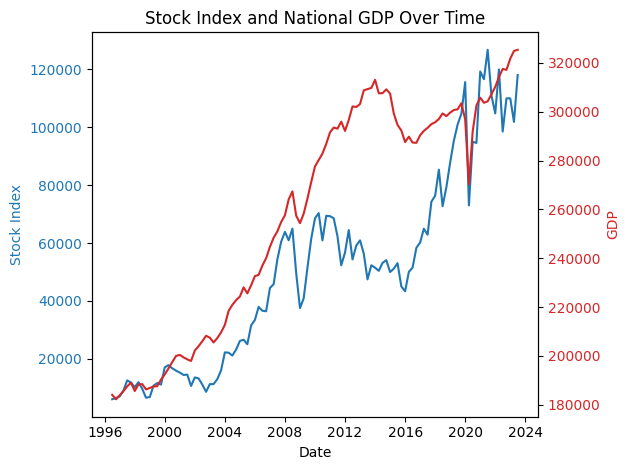

In [467]:
fig, ax1 = plt.subplots()

# Plot the Price data on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Index', color=color)
ax1.plot(price_df.index, price_df['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the GDP data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('GDP', color=color)  # we already handled the x-label with ax1
ax2.plot(price_df.index, price_df['GDP'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Stock Index and National GDP Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Show the plot
plt.show()


Run a cointegration test to see if GDP and National Stock Market indicies are Cointegrated. This is crucial for ensuring we have a valid econometric model. VEC works with cointegrated stationary series. 

Cointegration Test: Cointegration tests are used to determine whether two or more time series move together in the long run, indicating a stable, long-term relationship.

Johansen Test: The Johansen test is a multivariate cointegration test that can detect multiple cointegrating relationships.
T
race Statistics: These are used to test the null hypothesis of no cointegration against the alternative of cointegration.

Critical Values: Pre-determined values used to decide whether to reject the null hypothesis.

In [468]:
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

# Perform the Johansen cointegration test
data = price_df[['price_diff', 'GDP_diff']]

result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Print the Trace Statistics and Critical Values
print('Trace Statistics:', result.lr1)
print('Critical Values (90%, 95%, 99%):', result.cvt)

# Interpret and print whether cointegration is found
cointegration_found = False  # A flag to keep track of cointegration status
for i, trace_stat in enumerate(result.lr1):
    if trace_stat > result.cvt[i][1]:  # Index 1 is for the 95% confidence level
        cointegration_found = True
        print(f"At the 95% confidence level, we reject the null hypothesis of at most {i} cointegrating relations; indicating cointegration.")
    else:
        print(f"At the 95% confidence level, we fail to reject the null hypothesis of at most {i} cointegrating relations; no cointegration indicated.")

# Print overall result based on tests
if cointegration_found:
    print("The series exhibit a long-run cointegrating relationship.")
else:
    print("No long-run cointegrating relationship is evident among the series.")


Trace Statistics: [117.59987752  55.42048424]
Critical Values (90%, 95%, 99%): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
At the 95% confidence level, we reject the null hypothesis of at most 0 cointegrating relations; indicating cointegration.
At the 95% confidence level, we reject the null hypothesis of at most 1 cointegrating relations; indicating cointegration.
The series exhibit a long-run cointegrating relationship.


Implications:
Long-run equilibrium: The presence of cointegration suggests that the differenced price and GDP move together over the long run, maintaining a stable relationship.

Economic interpretation: This long-run relationship demonstrates the positive relationship between GDP growth and stock market performance. Since we can use a VEC model to predict the movement  of the stock market and GDP in the future, we can also investigate wether there is explosive speculative behavior inherent in the forecast. 

Forecasting and Policy: The cointegrated relationship can be used to improve forecasting models and inform economic policy decisions aimed at maintaining financial stability.


Seasonality: It is also important to investigate seasonal effects on our GDP and Stock Market Data. To achieve this, we decompose the time series data into its seasonal, trend, and residual components. The code uses the seasonal_decompose function from the statsmodels library to perform this decomposition for both the stock market price differences and the GDP differences, assuming the data is quarterly (period=4). The resulting components are then plotted to visualize the seasonal patterns.

Additionally, the code includes a function to perform a Fast Fourier Transform (FFT) on the time series data, which helps identify the dominant frequencies and cyclic behavior within the data. The FFT results for both the stock market price differences and the GDP differences are plotted to further investigate any underlying periodicities.

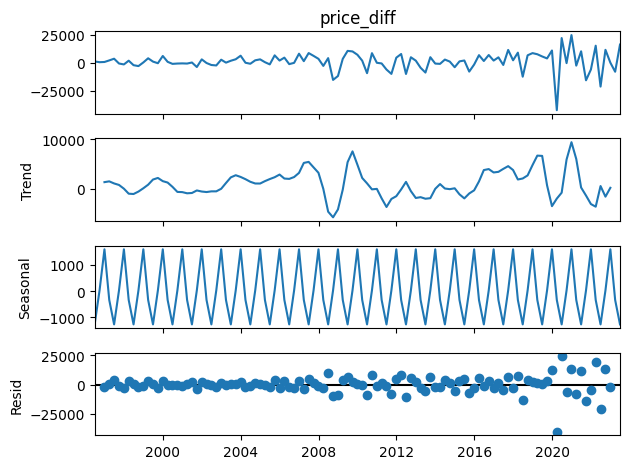

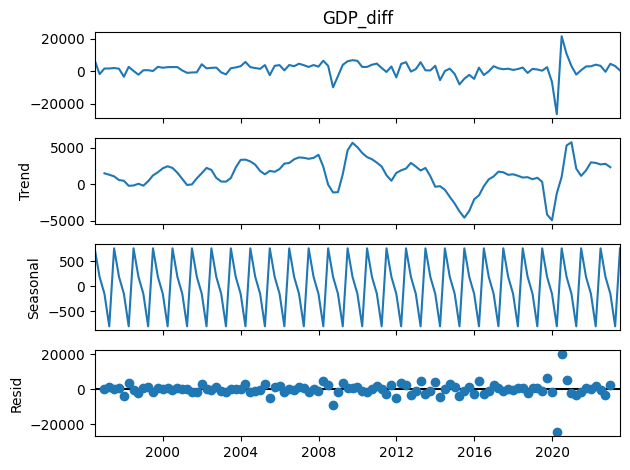

In [469]:

# Decompose stock market data
result_price = seasonal_decompose(data['price_diff'], model='additive', period=4)  # Quarterly data, adjust 'period' as needed
result_price.plot()
plt.show()

# Decompose GDP data
result_gdp = seasonal_decompose(data['GDP_diff'], model='additive', period=4)  # Quarterly data, adjust 'period' as needed
result_gdp.plot()
plt.show()


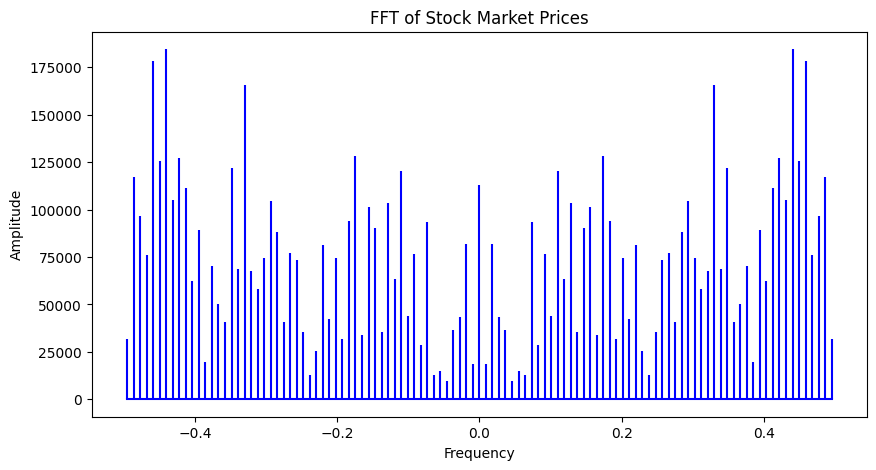

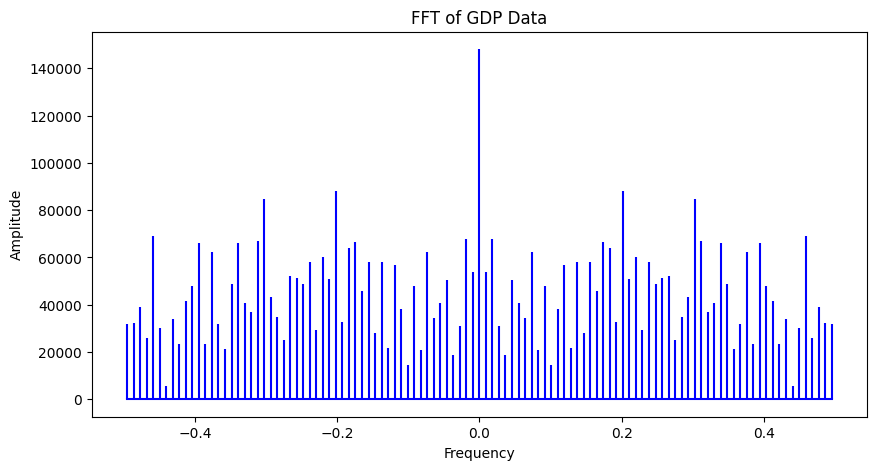

In [470]:

def plot_fft(series, title):
    # Compute the fast Fourier Transform
    n = len(series)
    freq = np.fft.fftfreq(n)
    fft_series = np.fft.fft(series)
    plt.figure(figsize=(10, 5))
    plt.stem(freq, np.abs(fft_series), 'b', markerfmt=" ", basefmt="-b")
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.show()

plot_fft(price_df['price_diff'], 'FFT of Stock Market Prices')
plot_fft(price_df['GDP_diff'], 'FFT of GDP Data')


We see potential evidence of seasonality with stock price, while we are less sure about gdp. fluctuations outside the mean are small

Central Peak:
Low-Frequency Dominance: This central peak at or near zero frequency suggests that the primary component of your time series is a trend. This means the long-term direction of the stock prices is a significant feature of the data.
Side Peaks:
Seasonal or Cyclical Effects: The presence of additional peaks at regular intervals could indicate seasonal effects, assuming the data's time frame captures full seasonal cycles (e.g., quarterly or annually). The distance between these peaks can give an indication of the periodicity of the seasonal or cyclical components.

This code is part of a time series analysis process aimed at fitting a Vector Error Correction Model (VECM) to the data, which in this case consists of differenced price and GDP values. The select_order function determines the optimal number of lags to include in the VECM. The function evaluates various lag lengths (up to a maximum of 10) and selects the optimal lag order based on criteria such as AIC, BIC, HQIC, and FPE. This ensures that the model captures the dynamics of the data accurately without overfitting.

After determining the optimal lag order, we test for the rank of cointegration using the select_coint_rank function. This function performs the Johansen cointegration test to determine the number of cointegrating relationships among the variables. The test uses the trace statistic method, considering up to 3 lags and a significance level of 0.05. The summary() method of the resulting object prints a detailed summary of the test results, indicating whether and how many cointegrating relationships exist. This step is crucial for understanding the long-term equilibrium relationships among the time series and for accurately specifying the VECM.

In [471]:
from statsmodels.tsa.vector_ar.vecm import select_order

# Fit the model
# Determine the optimal lag order
lag_order = select_order(data=data, maxlags=10, deterministic="ci")
print(lag_order.summary())
optimal_lags = lag_order.aic


 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        34.73      34.94*   1.213e+15      34.82*
1        34.72       35.04   1.200e+15       34.85
2        34.71       35.13   1.182e+15       34.88
3        34.74       35.26   1.219e+15       34.95
4       34.62*       35.25  1.089e+15*       34.88
5        34.69       35.43   1.165e+15       34.99
6        34.69       35.53   1.166e+15       35.03
7        34.70       35.65   1.190e+15       35.09
8        34.73       35.79   1.230e+15       35.16
9        34.76       35.92   1.267e+15       35.23
10       34.78       36.04   1.295e+15       35.29
--------------------------------------------------


In [472]:
rank_test = select_coint_rank(data, 0, optimal_lags, method="trace",
                              signif=0.05)
rank_test.summary()


r_0,r_1,test statistic,critical value
0,2,50.73,15.49
1,2,8.733,3.841


The Johansen trace test results indicate that there is exactly one cointegrating relationship between the variables. This means the variables share a long-run equilibrium relationship, but there is no evidence for more than one such relationship. This finding supports the presence of a stable long-term relationship between the differenced stock index prices and GDP, consistent with the theory of cointegration in economic time series.

VECM Model: setting up a VECM with the specified lag order and cointegration rank, examining both short-term dynamics and long-term equilibrium relationships in the data. 


In [473]:
model = VECM(data, deterministic="ci", seasons=2, k_ar_diff = optimal_lags, coint_rank= 2)

In [474]:
vecm_res = model.fit()
vecm_res.summary()



,coef,std err,z,P>|z|,[0.025,0.975]
season1,190.5026,1386.324,0.137,0.891,-2526.643,2907.649
L1.price_diff,0.2308,0.267,0.866,0.387,-0.292,0.753
L1.GDP_diff,0.8642,0.362,2.386,0.017,0.154,1.574
L2.price_diff,0.1031,0.227,0.455,0.649,-0.341,0.547
L2.GDP_diff,1.1430,0.325,3.521,0.000,0.507,1.779
L3.price_diff,0.1570,0.179,0.879,0.379,-0.193,0.507
L3.GDP_diff,0.6767,0.257,2.629,0.009,0.172,1.181
L4.price_diff,0.0456,0.114,0.400,0.689,-0.178,0.269
L4.GDP_diff,0.4897,0.192,2.550,0.011,0.113,0.866
,coef,std err,z,P>|z|,[0.025,0.975]


Plotting GDP and Stock Market Predictions

array([[-8017.47065282,  1638.14885508],
       [ 2108.23698713,  1837.64620149],
       [ 2034.46652026,   641.58018906],
       [-2420.87861338,  3072.33090697],
       [ 3404.02766986,   199.40200489],
       [  697.49475078,  1703.71092574],
       [ -788.40807409,  1626.24857925],
       [ 3190.11062839,  1346.87539983],
       [ -934.37272605,  1374.76243399],
       [ 1925.96343266,  1641.63014405],
       [  804.20674997,   831.75650524],
       [  463.30363896,  1900.58665605],
       [ 1199.64464192,   979.66713456],
       [ 1135.28654873,  1653.7265842 ],
       [  374.15132914,  1120.51117222],
       [ 1712.03099714,  1549.92633535],
       [  202.53249711,  1114.42503681],
       [ 1466.36343351,  1642.41188038],
       [  618.99538846,  1015.0131384 ],
       [ 1189.39902575,  1671.77955   ],
       [  680.23707225,  1019.87893613],
       [ 1292.86151878,  1639.67767554],
       [  518.02028147,  1061.02116516],
       [ 1425.6542192 ,  1612.81903874],
       [  482.85

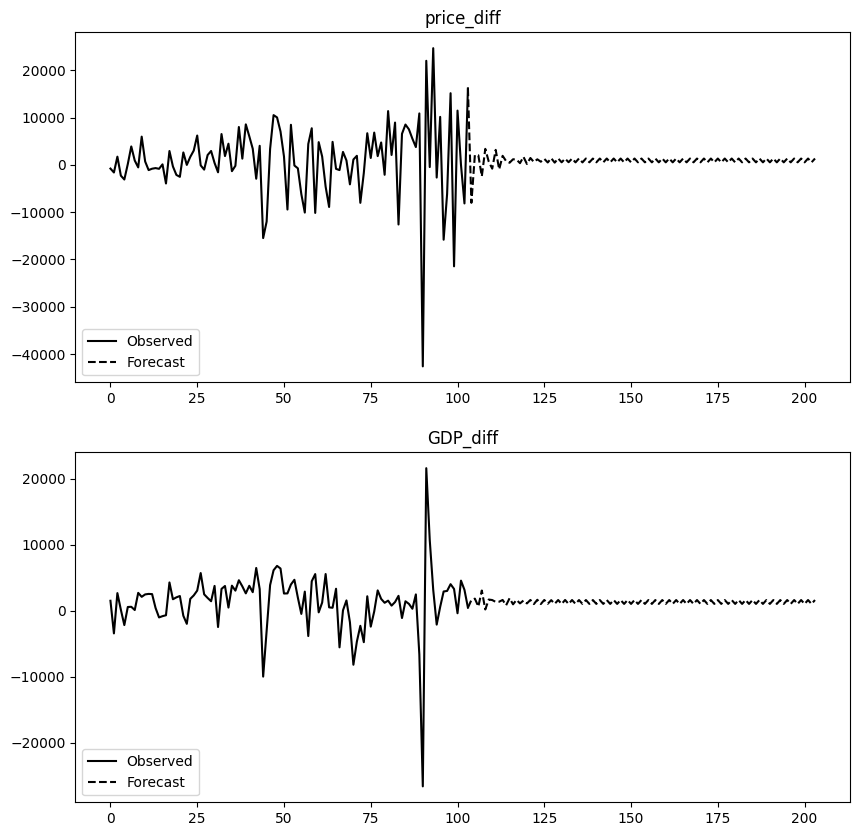

In [475]:
vecm_res.plot_forecast(steps=100, plot_conf_int=False)
df = vecm_res.predict(steps=100)
df

Impulse Response Function (IRF): While VECMs aren't typically used for impulse response analysis in the same way VAR models are, we've included an IRF generation. This helps in analyzing how a shock to one variable affects others over time within the VECM framework.



Takning the differenced forcasts and using them to find predicted GDP and stock price levels

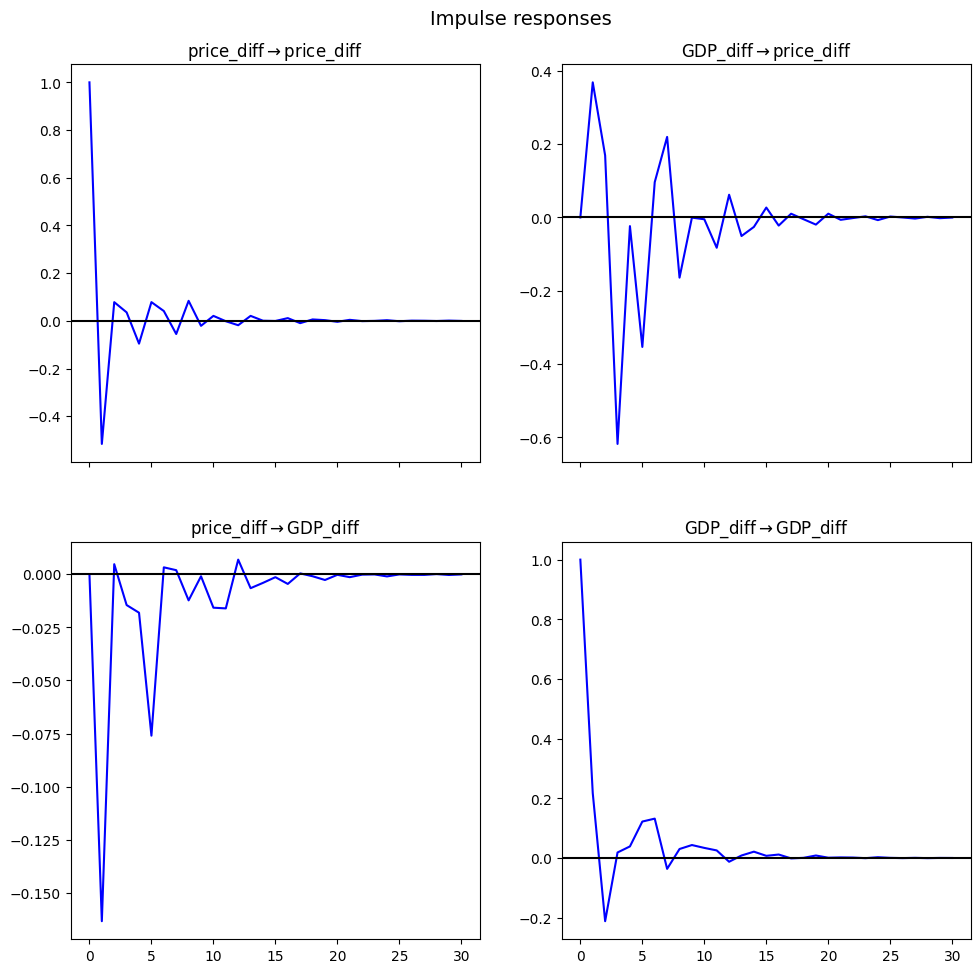

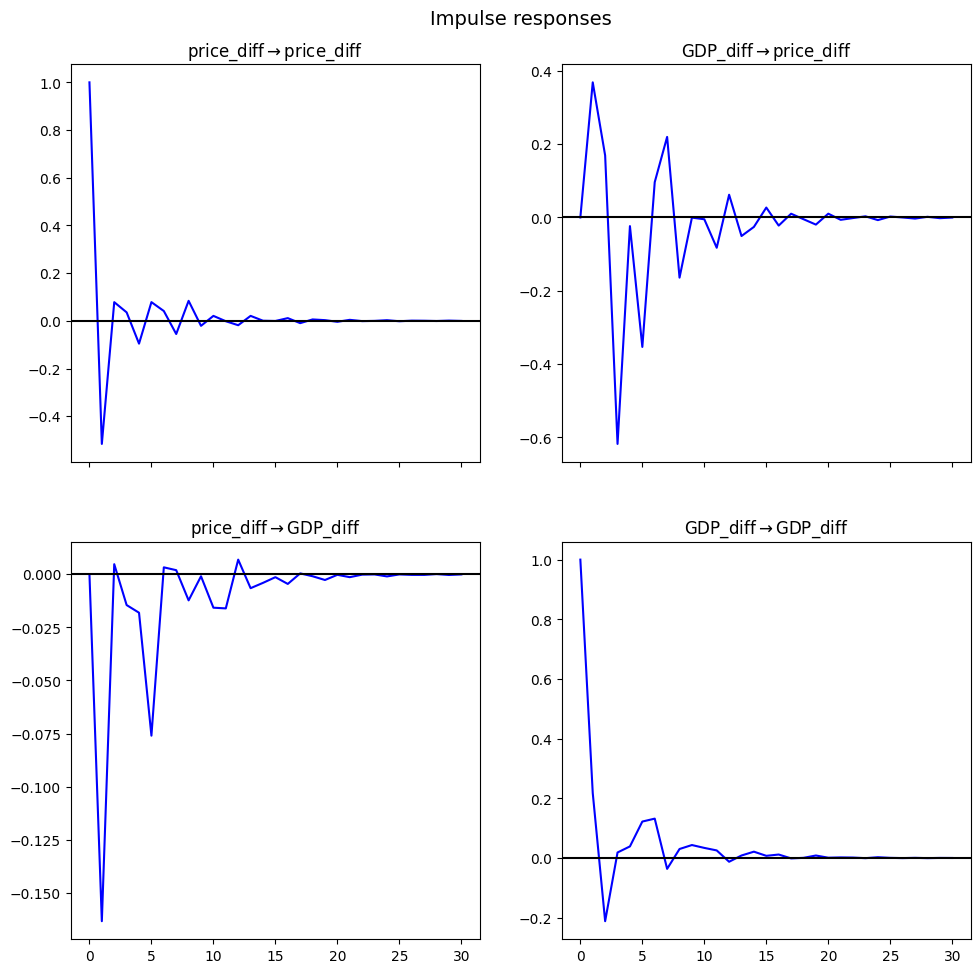

In [476]:
num_periods = 30
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

Forecast Level Calculation:

add the forecasted differences back to the last observed level, making the output interpretable in the original data's context.

In [477]:
from dateutil.relativedelta import relativedelta

# Last observed level data
last_gdp = price_df['GDP'].iloc[-1]
last_price = price_df['price'].iloc[-1]

# Forecast of differenced data
forecast_diff = df

# Add differences to the last observed level data
forecast_gdp = last_gdp + np.cumsum(forecast_diff[:, 1])
forecast_price = last_price + np.cumsum(forecast_diff[:, 0])


# Get the last date in price_df.index
last_date = price_df.index[-1]

# Add one quarter to the last date
forecast_date = last_date + relativedelta(months=+3)

# Create forecast_dates using pd.date_range
forecast_dates = pd.date_range(start=forecast_date, periods=len(forecast_diff), freq='Q')
forecast_df = pd.DataFrame({
    'price': forecast_price,
    'GDP': forecast_gdp,
    'price_diff': forecast_diff[:, 1],
    'GDP_diff': forecast_diff[:, 0]
}, index=forecast_dates)

forecast_df

/var/folders/gj/ntyx2j3d1rdf_dqn_fckn5pr0000gn/T/ipykernel_55191/4072819314.py:22: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_dates = pd.date_range(start=forecast_date, periods=len(forecast_diff), freq='Q')


,price,GDP,price_diff,GDP_diff
2023-09-30,110069.529347,326955.348855,1638.148855,-8017.470653
2023-12-31,112177.766334,328792.995057,1837.646201,2108.236987
2024-03-31,114212.232855,329434.575246,641.580189,2034.466520
2024-06-30,111791.354241,332506.906153,3072.330907,-2420.878613
2024-09-30,115195.381911,332706.308157,199.402005,3404.027670
...,...,...,...,...
2047-06-30,200824.438499,455381.705447,1628.991639,1354.349624
2047-09-30,201373.072605,456423.480835,1041.775388,548.634105
2047-12-31,202727.422241,458052.472475,1628.991640,1354.349636
2048-03-31,203276.056368,459094.247855,1041.775380,548.634127


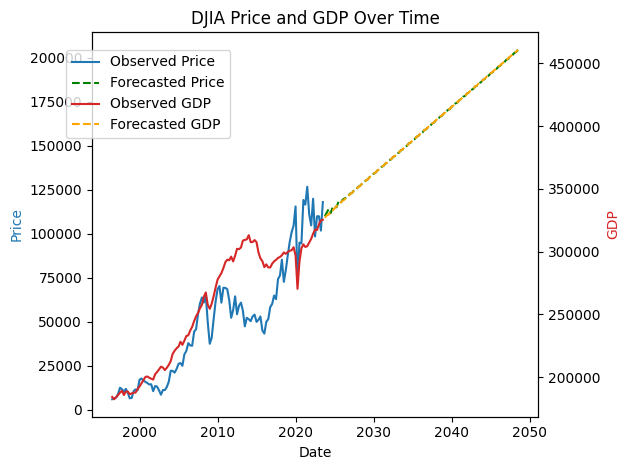

In [478]:
import matplotlib.pyplot as plt

# Plotting observed Price data
fig, ax1 = plt.subplots()

color_observed = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color_observed)
ax1.plot(price_df.index, price_df['price'], color=color_observed, label='Observed Price')

# Plotting forecasted Price data
ax1.plot(forecast_df.index, forecast_df['price'], linestyle='--', color='green', label='Forecasted Price')

# Create a second y-axis for the GDP data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_gdp = 'tab:red'
ax2.set_ylabel('GDP', color=color_gdp)
ax2.plot(price_df.index, price_df['GDP'], color=color_gdp, label='Observed GDP')
ax2.plot(forecast_df.index, forecast_df['GDP'], linestyle='--', color='orange', label='Forecasted GDP')

# Title and legend
plt.title('DJIA Price and GDP Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()


merge observed values with prediction

In [479]:
merged_df = pd.concat([price_df, forecast_df])
T = len(merged_df)
T
price = merged_df['price']

The SADF test involves calculating the Augmented Dickey-Fuller (ADF) statistic over a rolling window to detect explosive behavior in time series data. For each possible endpoint of the rolling window, the ADF statistic is computed, and the Supremum ADF Statistic (SADF) is the maximum ADF statistic from all windows, indicating the strongest evidence of explosive behavior. The GSADF test extends the SADF by considering multiple start points within the rolling window. For each endpoint of the window, ADF statistics are calculated for all possible start points, and the Generalized Supremum ADF Statistic (GSADF) is the maximum of these, providing a more robust test by considering a wider range of potential explosive periods.

To determine the critical values for the SADF and GSADF tests, a large number of random walks (unit root processes) are simulated. For each simulated series, the ADF statistic is calculated, and the critical values at the 90%, 95%, and 99% significance levels are derived from the distribution of these ADF statistics. These simulated critical values serve as benchmarks for assessing the significance of the SADF and GSADF statistics calculated from the observed data. If the SADF or GSADF statistic exceeds the critical value at a given significance level, it suggests the presence of explosive behavior, indicating a potential bubble.

In [480]:
# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1
date = pd.date_range(start=start, periods=T, freq='Q-DEC')

def simulate_critical_values(num_simulations, T, r0):
    critical_values = []
    for _ in range(num_simulations):
        # Generate a unit root process
        series = np.random.normal(size=T).cumsum()
        # Placeholder for SADF/GSADF calculation: this should ideally be replaced
        # with a function that calculates the SADF/GSADF statistic.
        stat = adfuller(series, maxlag=int(r0*T), regression='c', autolag=None)[0]
        critical_values.append(stat)
    
    # Determine the 90%, 95%, and 99% critical values
    critical_values = np.percentile(critical_values, [90, 95, 99])
    return critical_values

# Example usage
num_simulations = 2000

critical_values = simulate_critical_values(num_simulations, T, r0)
print("Critical values at 90%, 95%, 99%:", critical_values)


/var/folders/gj/ntyx2j3d1rdf_dqn_fckn5pr0000gn/T/ipykernel_55191/1900666469.py:5: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  date = pd.date_range(start=start, periods=T, freq='Q-DEC')


Critical values at 90%, 95%, 99%: [-0.19940799  0.26965675  1.17514141]


In [481]:
# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(price[:i+1], maxlag=2, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)

The SADF statistic: 2.611792955295744


In [482]:
# Calculate the Generalized SADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(price[r1:r2+1], maxlag=2, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', critical_values)

The GSADF statistic: 2.9410722053194176
The critical values: [-0.19940799  0.26965675  1.17514141]


In [483]:
print(len(dateS), len(bsadfs), len(badfs)) 


181 182 182


In [484]:
# Removing excess values not in the date range
badfs_plt = badfs[:-1]
bsadfs_plt = bsadfs[:-1]

These plots help in visually identifying periods where the test statistics exceed the critical values, indicating potential financial bubbles or explosive behavior in the time series data.

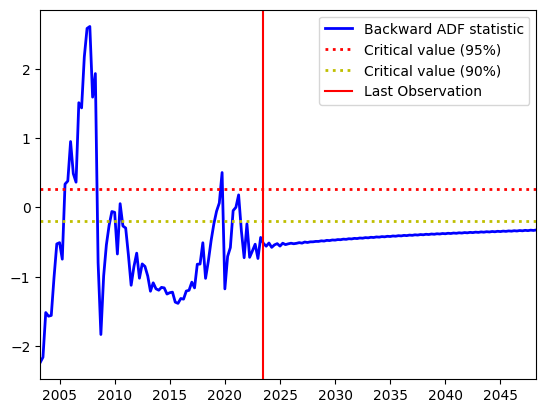

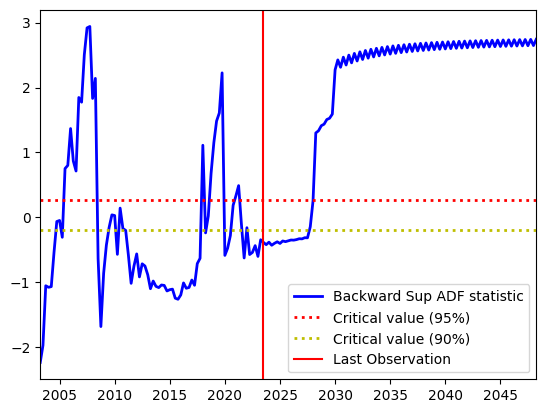

In [485]:
# Plot the backward ADF statistics
plt.figure(1)
plt.plot(dateS, badfs_plt, '-b', linewidth=2)
plt.plot(dateS, [critical_values[1]] * len(dateS), ':r', linewidth=2)
plt.plot(dateS, [critical_values[0]] * len(dateS), ':y', linewidth=2)
plt.axvline(last_date, color='r', linestyle='-')  # Add vertical line at last_date
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward ADF statistic', 'Critical value (95%)', 'Critical value (90%)','Last Observation'])

# Plot the Generalized SADF statistics
plt.figure(2)
plt.plot(dateS, bsadfs_plt, '-b', linewidth=2)
plt.plot(dateS, [critical_values[1]] * len(dateS), ':r', linewidth=2)
plt.plot(dateS, [critical_values[0]] * len(dateS), ':y', linewidth=2)
plt.axvline(last_date, color='r', linestyle='-')  # Add vertical line at last_date
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward Sup ADF statistic', 'Critical value (95%)','Critical value (90%)', 'Last Observation'])

plt.savefig(f'{path}/Asset-Price-Bubble-Detection//results/Brazil_Unit_Root_GDP.jpeg', format='jpeg')

plt.show()
